In [164]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

In [165]:
# Load
df = pd.read_csv('uganda_traffic_forecasting.csv')

# Dataset preview
print(df.shape)
display(df.head())


(1538, 11)


,timestamp,location_id,vehicle_count,avg_speed,weather,day_of_week,is_holiday,event,sensor_status,road_condition,target_congestion_level
0,2023-01-01 03:00:00,ENT002,23.0,40.72036861283745,Clear,Thursday,0.0,Parade,FAIL,Good,0.0
1,2023-01-01 03:15:00,GUL004,15.0,37.87791030098848,Rainy,Tuesday,0.0,Parade,FAIL,Poor,1.0
2,2023-01-01 03:30:00,GUL004,21.0,30.480815399777644,Clear,Saturday,1.0,Marathon,OK,Moderate,2.0
3,2023-01-01 03:45:00,MBR003,25.0,40.774805185188626,Rainy,Monday,0.0,NaN,UNKNOWN,???,0.0
4,2023-01-01 04:00:00,GUL004,15.0,42.57752540142751,Snowy,Friday,0.0,Marathon,OK,Moderate,1.0


In [166]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   timestamp                1537 non-null   object
 1   location_id              1534 non-null   object
 2   vehicle_count            1536 non-null   object
 3   avg_speed                1537 non-null   object
 4   weather                  1533 non-null   object
 5   day_of_week              1533 non-null   object
 6   is_holiday               1534 non-null   object
 7   event                    1155 non-null   object
 8   sensor_status            1538 non-null   object
 9   road_condition           1536 non-null   object
 10  target_congestion_level  1537 non-null   object
dtypes: object(11)
memory usage: 132.3+ KB


None

In [167]:
# Replace the string '???' with NumPy's Not a Number (NaN)
df.replace('???', np.nan, inplace=True)

print("Replaced all '???' strings with np.nan.")

Replaced all '???' strings with np.nan.


In [168]:
# Convert 'timestamp' to a proper datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Define which columns should be numbers
numeric_cols = ['vehicle_count', 'avg_speed', 'is_holiday', 'target_congestion_level']

# Convert the numeric columns, turning any conversion errors into NaN
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("Converted columns to their correct data types.")
display(df.info())

Converted columns to their correct data types.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   timestamp                1533 non-null   datetime64[ns]
 1   location_id              1529 non-null   object        
 2   vehicle_count            1528 non-null   float64       
 3   avg_speed                1533 non-null   float64       
 4   weather                  1529 non-null   object        
 5   day_of_week              1533 non-null   object        
 6   is_holiday               1527 non-null   float64       
 7   event                    1147 non-null   object        
 8   sensor_status            1534 non-null   object        
 9   road_condition           1533 non-null   object        
 10  target_congestion_level  1532 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(6)
memo

None

In [169]:
# Check for duplicate rows before removal
initial_duplicates = df.duplicated().sum()
print(f"Found {initial_duplicates} duplicate rows.")

# Remove duplicate rows
df.drop_duplicates(inplace=True)
print(f"Removed {initial_duplicates} duplicate rows.")

# Verify that duplicates are gone
remaining_duplicates = df.duplicated().sum()
print(f"Remaining duplicates: {remaining_duplicates}")

Found 72 duplicate rows.
Removed 72 duplicate rows.
Remaining duplicates: 0


In [170]:
print("----Missing values per column:----\n")
print(df.isnull().sum())

----Missing values per column:----

timestamp                    5
location_id                  8
vehicle_count               10
avg_speed                    5
weather                      9
day_of_week                  5
is_holiday                  11
event                      376
sensor_status                4
road_condition               5
target_congestion_level      6
dtype: int64


In [171]:
# --- Fill missing values (Imputation) ---

# For categorical columns, fill with the most frequent value (mode)
for col in ['location_id', 'weather', 'day_of_week', 'event', 'road_condition', 'sensor_status']:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

# For numerical columns, fill with the median or mean
df['vehicle_count'] = df['vehicle_count'].fillna(df['vehicle_count'].median())
df['avg_speed'] = df['avg_speed'].fillna(df['avg_speed'].mean())
df['is_holiday'] = df['is_holiday'].fillna(0)  # Assume not a holiday if unknown
df['target_congestion_level'] = df['target_congestion_level'].fillna(df['target_congestion_level'].median())

# Drop any rows where the timestamp could not be converted (it becomes NaT)
df.dropna(subset=['timestamp'], inplace=True)

print("Handled all missing values.")
print("Missing values per column:\n", df.isnull().sum())
print(df.shape)


Handled all missing values.
Missing values per column:
 timestamp                  0
location_id                0
vehicle_count              0
avg_speed                  0
weather                    0
day_of_week                0
is_holiday                 0
event                      0
sensor_status              0
road_condition             0
target_congestion_level    0
dtype: int64
(1461, 11)


 Detecting outliers in 'vehicle_count' and 'avg_speed'...


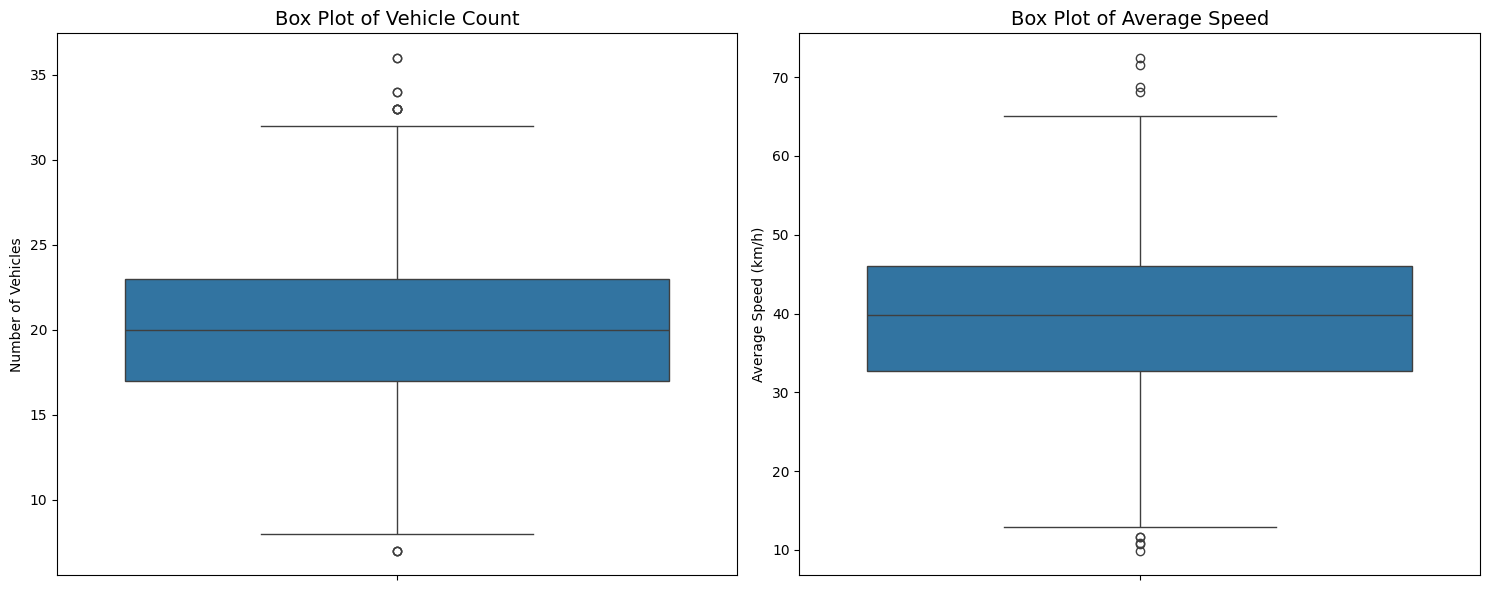


--- Analysis for 'vehicle_count' ---
Lower Bound: 8.00
Upper Bound: 32.00
Number of outliers detected: 12

--- Analysis for 'avg_speed' ---
Lower Bound: 12.66
Upper Bound: 66.06
Number of outliers detected: 9


In [172]:
# checking for outliers using a box plot
import matplotlib.pyplot as plt
import seaborn as sns

print(" Detecting outliers in 'vehicle_count' and 'avg_speed'...")

# Create a figure to hold the subplots
plt.figure(figsize=(15, 6))

# Subplot 1: Box plot for 'vehicle_count'
plt.subplot(1, 2, 1)
sns.boxplot(y=df['vehicle_count'])
plt.title('Box Plot of Vehicle Count', fontsize=14)
plt.ylabel('Number of Vehicles')

# Subplot 2: Box plot for 'avg_speed'
plt.subplot(1, 2, 2)
sns.boxplot(y=df['avg_speed'])
plt.title('Box Plot of Average Speed', fontsize=14)
plt.ylabel('Average Speed (km/h)')

plt.tight_layout()
plt.show()

# --- Programmatic Detection using IQR ---
for col in ['vehicle_count', 'avg_speed']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"\n--- Analysis for '{col}' ---")
    print(f"Lower Bound: {lower_bound:.2f}")
    print(f"Upper Bound: {upper_bound:.2f}")
    print(f"Number of outliers detected: {len(outliers)}")

Handling outliers by capping...
Outliers have been capped.

Verifying that outliers have been handled...


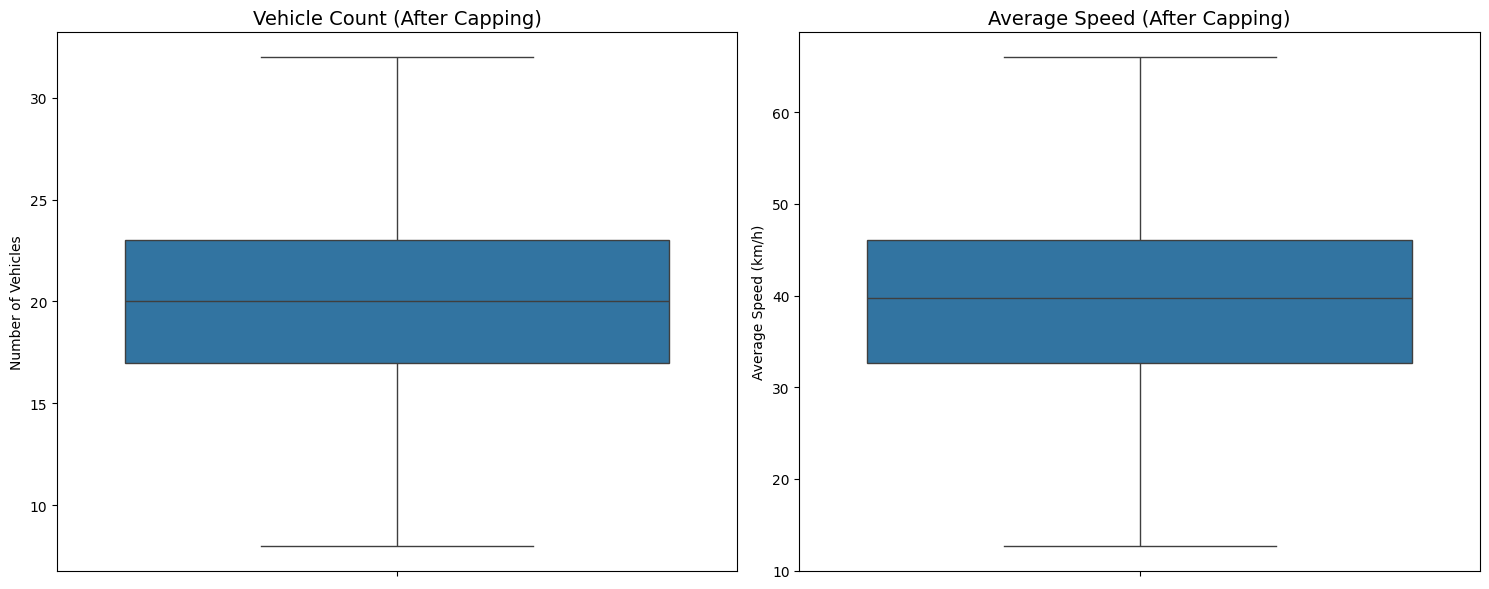

In [173]:
print("Handling outliers by capping...")

# Loop through the columns again to apply capping
for col in ['vehicle_count', 'avg_speed']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])

print("Outliers have been capped.")

# --- Verification ---
print("\nVerifying that outliers have been handled...")

plt.figure(figsize=(15, 6))

# Subplot 1: Box plot for 'vehicle_count' after capping
plt.subplot(1, 2, 1)
sns.boxplot(y=df['vehicle_count'])
plt.title('Vehicle Count (After Capping)', fontsize=14)
plt.ylabel('Number of Vehicles')

# Subplot 2: Box plot for 'avg_speed' after capping
plt.subplot(1, 2, 2)
sns.boxplot(y=df['avg_speed'])
plt.title('Average Speed (After Capping)', fontsize=14)
plt.ylabel('Average Speed (km/h)')

plt.tight_layout()
plt.show()

In [174]:
# Verify that the entire cleaning process worked
print("--- Final Cleaned Data Info ---")
df.info()



--- Final Cleaned Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 1461 entries, 0 to 1520
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   timestamp                1461 non-null   datetime64[ns]
 1   location_id              1461 non-null   object        
 2   vehicle_count            1461 non-null   float64       
 3   avg_speed                1461 non-null   float64       
 4   weather                  1461 non-null   object        
 5   day_of_week              1461 non-null   object        
 6   is_holiday               1461 non-null   float64       
 7   event                    1461 non-null   object        
 8   sensor_status            1461 non-null   object        
 9   road_condition           1461 non-null   object        
 10  target_congestion_level  1461 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 137.0+ KB


In [175]:
print("\n--- Final Missing Values Check ---")
# The output of this should be all zeros
print(df.isnull().sum())



--- Final Missing Values Check ---
timestamp                  0
location_id                0
vehicle_count              0
avg_speed                  0
weather                    0
day_of_week                0
is_holiday                 0
event                      0
sensor_status              0
road_condition             0
target_congestion_level    0
dtype: int64


In [176]:
print("\nData cleaning complete. The DataFrame is ready for saving.")
display(df.head())


Data cleaning complete. The DataFrame is ready for saving.


,timestamp,location_id,vehicle_count,avg_speed,weather,day_of_week,is_holiday,event,sensor_status,road_condition,target_congestion_level
0,2023-01-01 03:00:00,ENT002,23.0,40.720369,Clear,Thursday,0.0,Parade,FAIL,Good,0.0
1,2023-01-01 03:15:00,GUL004,15.0,37.877910,Rainy,Tuesday,0.0,Parade,FAIL,Poor,1.0
2,2023-01-01 03:30:00,GUL004,21.0,30.480815,Clear,Saturday,1.0,Marathon,OK,Moderate,2.0
3,2023-01-01 03:45:00,MBR003,25.0,40.774805,Rainy,Monday,0.0,Accident,UNKNOWN,Good,0.0
4,2023-01-01 04:00:00,GUL004,15.0,42.577525,Snowy,Friday,0.0,Marathon,OK,Moderate,1.0


In [177]:
# Save the final, cleaned DataFrame to a new CSV file.
# index=False prevents pandas from writing the DataFrame index as a column.
df.to_csv('df_cleaned.csv', index=False)

print("DataFrame successfully saved to 'df_cleaned.csv'")

DataFrame successfully saved to 'df_cleaned.csv'


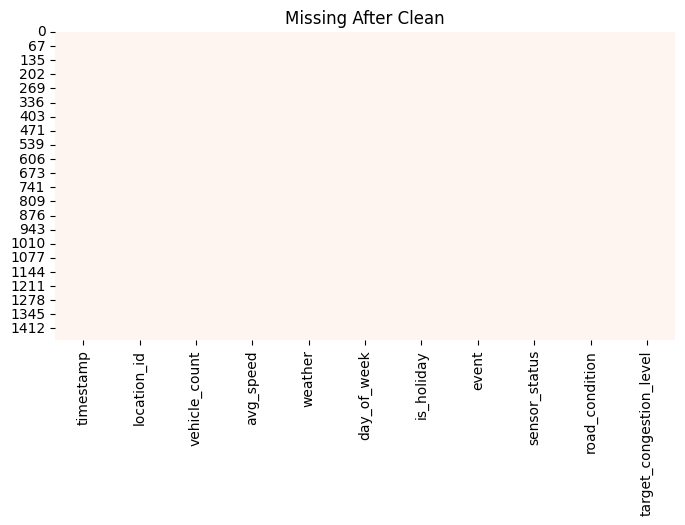

In [178]:
# 4.1 Missing‑value heatmap
plt.figure(figsize=(8,4))
sns.heatmap(df.isna(), cbar=False, cmap='Reds')
plt.title("Missing After Clean")
plt.show()

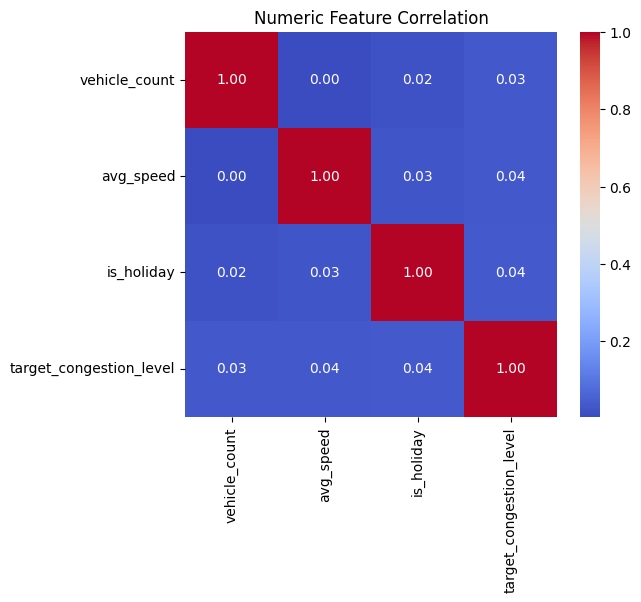

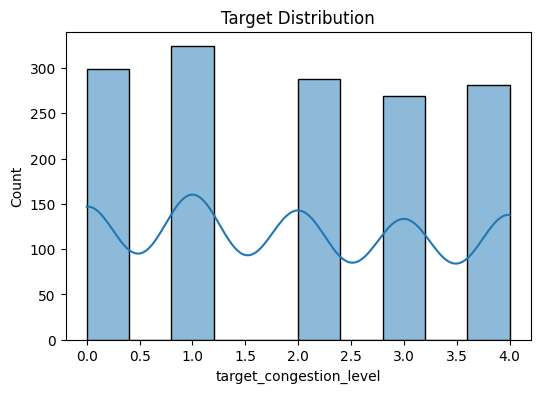

In [179]:
# Correlation of numeric features
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Numeric Feature Correlation")
plt.show()

# Distribution of target
plt.figure(figsize=(6,4))
sns.histplot(df['target_congestion_level'], bins=10, kde=True)
plt.title("Target Distribution")
plt.show()

In [180]:
# --- Evaluate the impact of new features on model performance ---

# 1. Baseline: Only original features (no engineered features)
base_features = ['vehicle_count', 'avg_speed', 'is_holiday', 'weather', 'road_condition', 'location_id']  # removed 'timestamp'
df_base = df.copy()
df_base = df_base.dropna(subset=base_features)  # drop rows with missing base features
X_base = pd.get_dummies(df_base[base_features], columns=['weather','road_condition','location_id'], drop_first=True)
y_base = pd.cut(df_base['target_congestion_level'], bins=[-1,1.5,3.5,5], labels=[0,1,2]).astype(int)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42, stratify=y_base)
rf_base = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42, class_weight='balanced')
rf_base.fit(Xb_train, yb_train)
yb_pred = rf_base.predict(Xb_test)
print('Baseline (no engineered features) Accuracy:', accuracy_score(yb_test, yb_pred))
print(classification_report(yb_test, yb_pred))

Baseline (no engineered features) Accuracy: 0.37542662116040953
              precision    recall  f1-score   support

           0       0.44      0.48      0.46       125
           1       0.38      0.42      0.40       112
           2       0.09      0.05      0.07        56

    accuracy                           0.38       293
   macro avg       0.30      0.32      0.31       293
weighted avg       0.35      0.38      0.36       293



In [181]:
import pandas as pd
import numpy as np

# --- Load the Cleaned Dataset ---
df = pd.read_csv('df_cleaned.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

df_feat = df.copy()


# --- SECTION 1: YOUR ORIGINAL FEATURES (with critical correction) --

# Time-based
df_feat['hour']       = df_feat['timestamp'].dt.hour
df_feat['weekday']    = df_feat['timestamp'].dt.dayofweek
df_feat['is_weekend'] = df_feat['weekday'].isin([5, 6]).astype(int)
df_feat['month']      = df_feat['timestamp'].dt.month

# Cyclical encoding for hour and month
df_feat['hour_sin']  = np.sin(2 * np.pi * df_feat['hour'] / 24)
df_feat['hour_cos']  = np.cos(2 * np.pi * df_feat['hour'] / 24)
df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month'] / 12)
df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month'] / 12)

# Traffic dynamics
df_feat['speed_per_vehicle'] = df_feat['avg_speed'] / (df_feat['vehicle_count'] + 1)
df_feat['veh_density']       = df_feat['vehicle_count'] / (df_feat['hour'] + 1)

# Interaction
df_feat['weather_road'] = df_feat['weather'] + '_' + df_feat['road_condition']


# The calculation MUST be grouped by location to prevent data leakage.
df_feat = df_feat.sort_values(['location_id', 'timestamp'])

# Lag features
df_feat['vehicle_count_lag1'] = df_feat.groupby('location_id')['vehicle_count'].shift(1)
df_feat['avg_speed_lag1']     = df_feat.groupby('location_id')['avg_speed'].shift(1)

# Rolling mean features
df_feat['vehicle_count_roll3'] = df_feat.groupby('location_id')['vehicle_count'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df_feat['avg_speed_roll3']     = df_feat.groupby('location_id')['avg_speed'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# --- Time-Based ---
# 1. Binned time of day
df_feat['time_of_day'] = pd.cut(df_feat['hour'], bins=[-1, 5, 9, 15, 19, 23], labels=['Night', 'Morning Rush', 'Midday', 'Afternoon Rush', 'Evening'])
# 2. Week of the year
df_feat['week_of_year'] = df_feat['timestamp'].dt.isocalendar().week
# 3. Indicator for a non-routine day
df_feat['is_special_day'] = ((df_feat['is_holiday'] == 1) | (df_feat['event'] != 'None')).astype(int)

# --- Cyclical---
# 4 & 5. Cyclical representation of the day of the week
df_feat['day_of_week_sin'] = np.sin(2 * np.pi * df_feat['weekday'] / 7)
df_feat['day_of_week_cos'] = np.cos(2 * np.pi * df_feat['weekday'] / 7)

# --- Historical / Lag ---
# 6. Previous congestion level
df_feat['congestion_lag1'] = df_feat.groupby('location_id')['target_congestion_level'].shift(1)
# 7. Vehicle count from 2 steps ago
df_feat['vehicle_count_lag2'] = df_feat.groupby('location_id')['vehicle_count'].shift(2)
# 8. Vehicle count from 3 steps ago
df_feat['vehicle_count_lag3'] = df_feat.groupby('location_id')['vehicle_count'].shift(3)

# --- Rolling Window Statistics ---
# 9. Max vehicle count in the last 3 periods
df_feat['vehicle_count_roll_max3'] = df_feat.groupby('location_id')['vehicle_count'].transform(lambda x: x.rolling(window=3, min_periods=1).max())
# 10. Min vehicle count in the last 3 periods
df_feat['vehicle_count_roll_min3'] = df_feat.groupby('location_id')['vehicle_count'].transform(lambda x: x.rolling(window=3, min_periods=1).min())
# 11. Standard deviation of speed in the last 3 periods (volatility)
df_feat['avg_speed_roll_std3'] = df_feat.groupby('location_id')['avg_speed'].transform(lambda x: x.rolling(window=3, min_periods=1).std())
# 12. Rate of change in vehicle count
df_feat['traffic_velocity'] = df_feat['vehicle_count'] - df_feat['vehicle_count_lag1']

# --- Advanced Interaction ---
# 13. Location and specific day of the week
df_feat['location_day'] = df_feat['location_id'] + '_' + df_feat['weekday'].astype(str)
# 14. Location and time of day bin
df_feat['location_time_of_day'] = df_feat['location_id'] + '_' + df_feat['time_of_day'].astype(str)
# 15. Time of day and road condition
df_feat['time_road_condition'] = df_feat['time_of_day'].astype(str) + '_' + df_feat['road_condition']

# --- Final Cleanup & Target ---
# Classification target
df_feat['congestion_class'] = pd.cut(
    df_feat['target_congestion_level'],
    bins=[-1, 1.5, 3.5, 5],
    labels=[0, 1, 2]
).astype(int)

# Drop rows with NA from lag/rolling features
df_feat = df_feat.dropna().reset_index(drop=True)

# --- Review ---
print("\nFeature engineering complete!")

# For absolute clarity, here is the list of the 15 new column names:
new_feature_names = [
    'time_of_day', 'week_of_year', 'is_special_day', 'day_of_week_sin',
    'day_of_week_cos', 'congestion_lag1', 'vehicle_count_lag2',
    'vehicle_count_lag3', 'vehicle_count_roll_max3', 'vehicle_count_roll_min3',
    'avg_speed_roll_std3', 'traffic_velocity', 'location_day',
    'location_time_of_day', 'time_road_condition'
]
print("\nList of the New Features Added:")
print(new_feature_names)

print("\nFinal DataFrame Head (with all features):")
display(df_feat.head())


Feature engineering complete!

List of the New Features Added:
['time_of_day', 'week_of_year', 'is_special_day', 'day_of_week_sin', 'day_of_week_cos', 'congestion_lag1', 'vehicle_count_lag2', 'vehicle_count_lag3', 'vehicle_count_roll_max3', 'vehicle_count_roll_min3', 'avg_speed_roll_std3', 'traffic_velocity', 'location_day', 'location_time_of_day', 'time_road_condition']

Final DataFrame Head (with all features):


,timestamp,location_id,vehicle_count,avg_speed,weather,day_of_week,is_holiday,event,sensor_status,road_condition,...,vehicle_count_lag2,vehicle_count_lag3,vehicle_count_roll_max3,vehicle_count_roll_min3,avg_speed_roll_std3,traffic_velocity,location_day,location_time_of_day,time_road_condition,congestion_class
0,2023-01-01 07:00:00,ENT002,17.0,50.826911,Foggy,Thursday,1.0,Accident,UNKNOWN,Poor,...,19.0,23.0,19.0,17.0,9.800337,-2.0,ENT002_6,ENT002_Morning Rush,Morning Rush_Poor,0
1,2023-01-01 07:45:00,ENT002,21.0,53.257966,Rainy,Monday,0.0,Accident,UNKNOWN,Good,...,19.0,19.0,21.0,17.0,11.981955,4.0,ENT002_6,ENT002_Morning Rush,Morning Rush_Good,1
2,2023-01-01 08:30:00,ENT002,25.0,39.564685,Rainy,Tuesday,0.0,Accident,OK,Poor,...,17.0,19.0,25.0,17.0,7.305862,4.0,ENT002_6,ENT002_Morning Rush,Morning Rush_Poor,0
3,2023-01-01 08:45:00,ENT002,17.0,50.383789,Foggy,Thursday,0.0,Accident,FAIL,Moderate,...,21.0,17.0,25.0,17.0,7.220571,-8.0,ENT002_6,ENT002_Morning Rush,Morning Rush_Moderate,0
4,2023-01-01 09:30:00,ENT002,24.0,35.488411,Snowy,Saturday,1.0,Accident,OK,Poor,...,25.0,21.0,25.0,17.0,7.697849,7.0,ENT002_6,ENT002_Morning Rush,Morning Rush_Poor,0


In [182]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# --- ADVANCED MODEL (Using ALL Engineered Features) ---

print("--- Training Advanced Model with ALL Engineered Features ---")

# Define target (y) and features (X)
# We drop original/redundant columns to avoid data leakage and noise
y_eng = df_feat['congestion_class']
X_eng = df_feat.drop(columns=[
    'congestion_class', 'target_congestion_level', 'timestamp', 'hour',
    'weekday', 'month', 'event', 'weather', 'road_condition', 'is_holiday'
])

# One-hot encode all remaining categorical features for the model
X_eng = pd.get_dummies(X_eng, drop_first=True)

# Split the data into training and testing sets
Xe_train, Xe_test, ye_train, ye_test = train_test_split(X_eng, y_eng, test_size=0.2, random_state=42, stratify=y_eng)

# print(f"\nTraining with {Xe_train.shape[1]} features.")

# Initialize and train the final model with your specified hyperparameters
rf_eng = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42, class_weight='balanced', n_jobs=-1)
rf_eng.fit(Xe_train, ye_train)

# Make predictions and evaluate the model's performance
ye_pred = rf_eng.predict(Xe_test)
engineered_accuracy = accuracy_score(ye_test, ye_pred)

print(f'\nWith ALL Engineered Features Accuracy: {engineered_accuracy:.4f}')
print("\n--- Classification Report ---")
print(classification_report(ye_test, ye_pred))

--- Training Advanced Model with ALL Engineered Features ---

With ALL Engineered Features Accuracy: 0.4379

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.47      0.68      0.55       124
           1       0.41      0.37      0.39       110
           2       0.22      0.04      0.06        56

    accuracy                           0.44       290
   macro avg       0.36      0.36      0.33       290
weighted avg       0.40      0.44      0.40       290



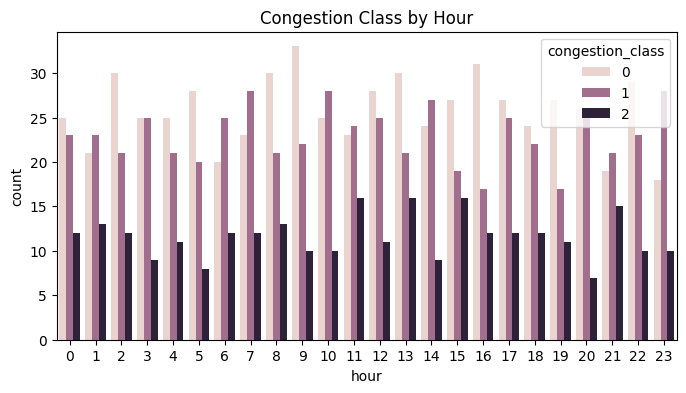

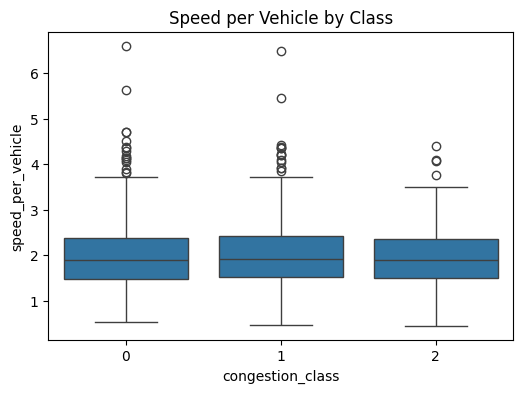

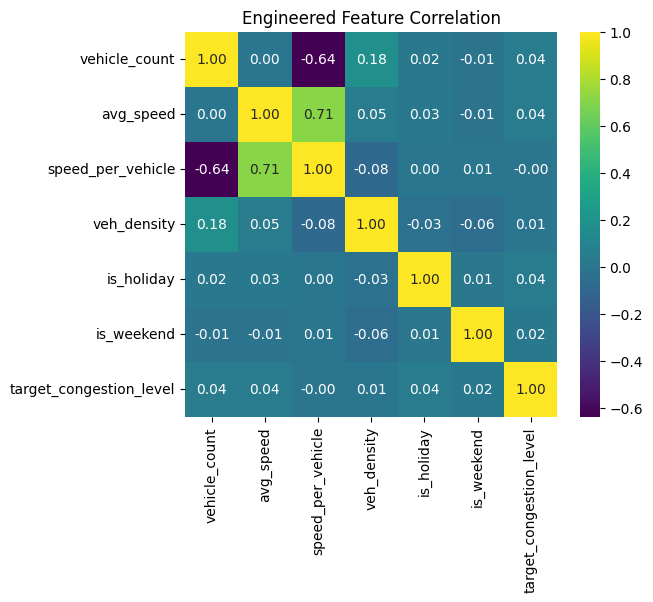

In [183]:
# Congestion by hour
plt.figure(figsize=(8,4))
sns.countplot(data=df_feat, x='hour', hue='congestion_class')
plt.title("Congestion Class by Hour"); plt.show()

# Boxplot: speed_per_vehicle vs class
plt.figure(figsize=(6,4))
sns.boxplot(data=df_feat, x='congestion_class', y='speed_per_vehicle')
plt.title("Speed per Vehicle by Class"); plt.show()

# Heatmap of key new features
cols = ['vehicle_count','avg_speed','speed_per_vehicle','veh_density','is_holiday','is_weekend','target_congestion_level']
plt.figure(figsize=(6,5))
sns.heatmap(df_feat[cols].corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title("Engineered Feature Correlation"); plt.show()


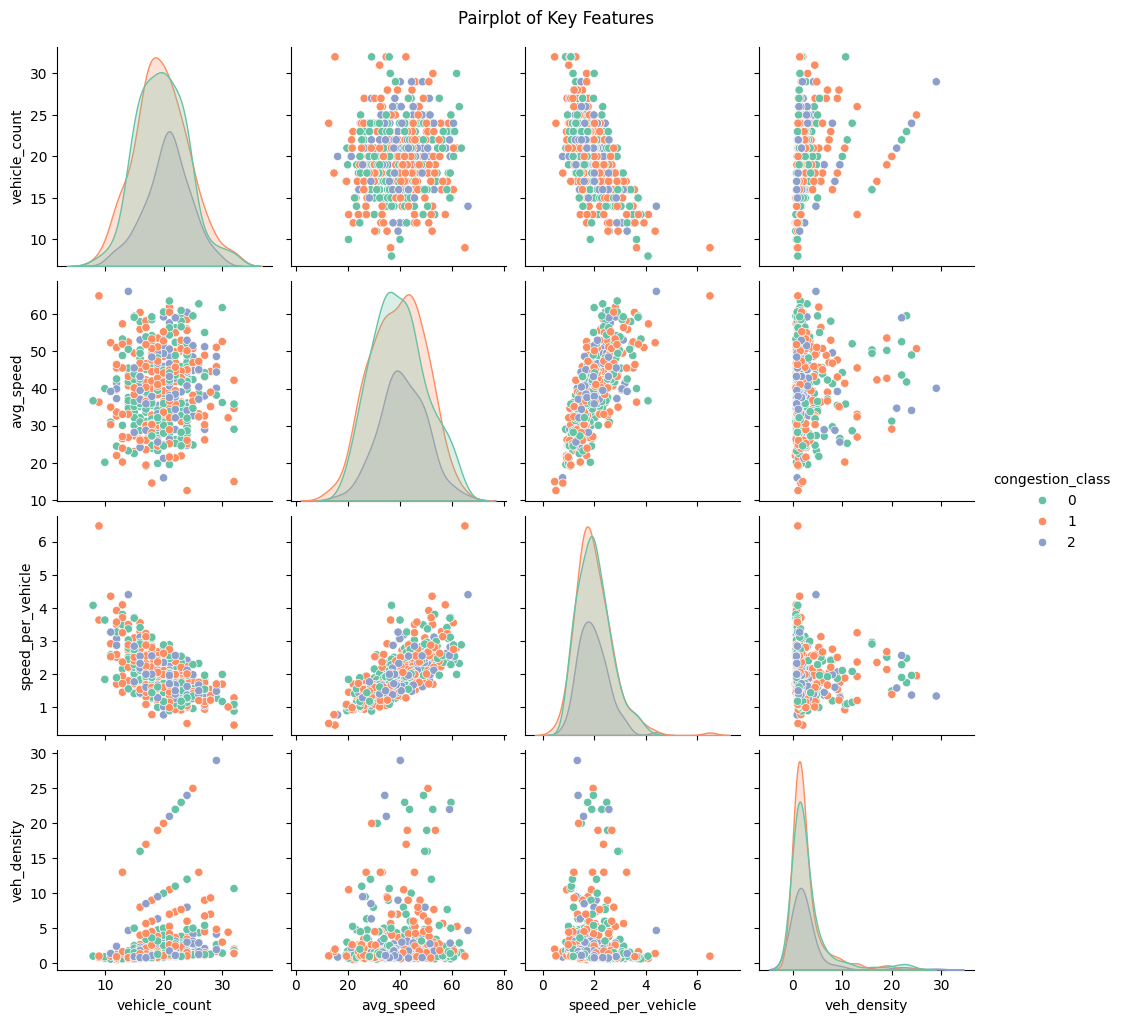

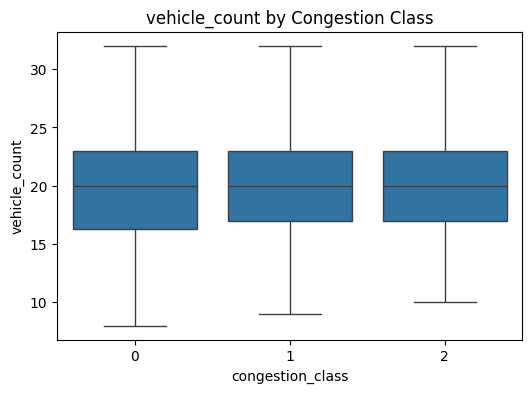

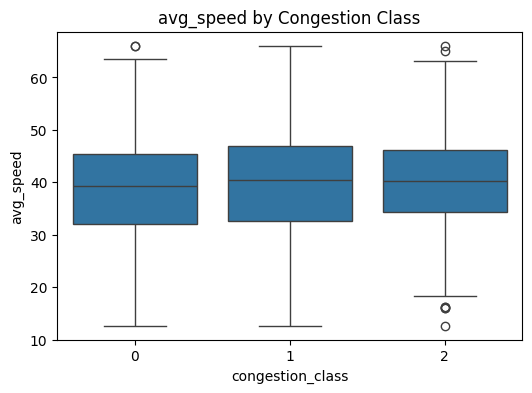

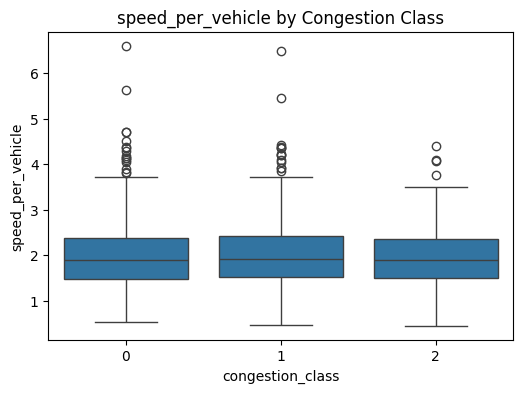

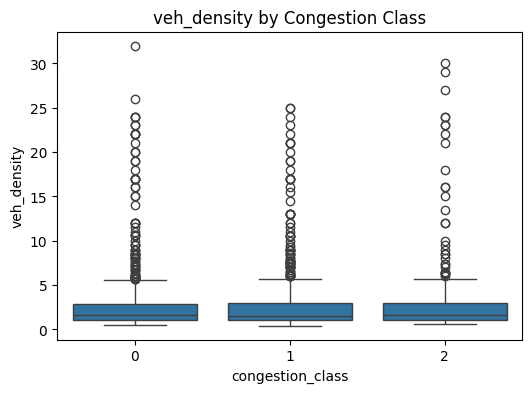

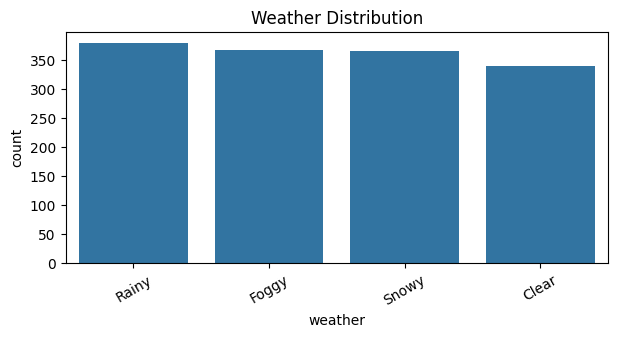

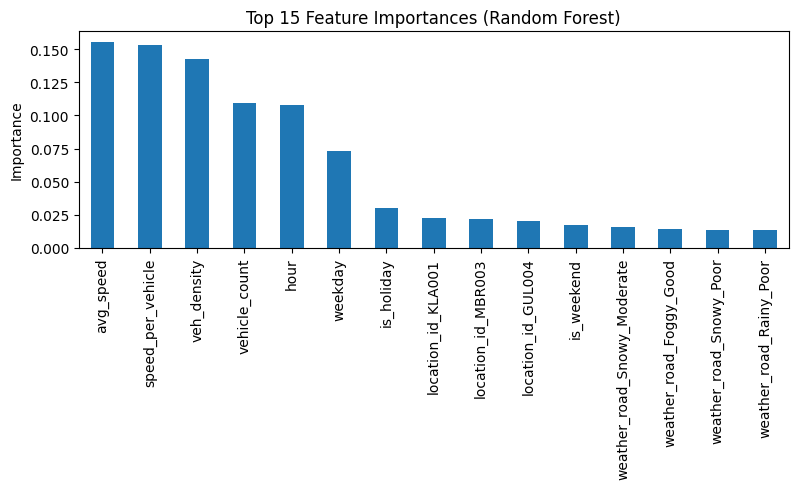

In [184]:
# Additional visualizations for deeper insights
import warnings
warnings.filterwarnings('ignore')

# 1. Pairplot of selected features (sampled for speed)
sample = df_feat.sample(n=min(500, len(df_feat)), random_state=42)
sns.pairplot(sample, vars=['vehicle_count','avg_speed','speed_per_vehicle','veh_density'], hue='congestion_class', palette='Set2')
plt.suptitle('Pairplot of Key Features', y=1.02); plt.show()


# 2. Boxplots for numeric features grouped by congestion class
num_cols = ['vehicle_count','avg_speed','speed_per_vehicle','veh_density']
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df_feat, x='congestion_class', y=col)
    plt.title(f'{col} by Congestion Class')
    plt.show()


# 3. Countplot for weather
if 'weather' in df_feat.columns:
    plt.figure(figsize=(7,3))
    sns.countplot(data=df_feat, x='weather', order=df_feat['weather'].value_counts().index)
    plt.title('Weather Distribution')
    plt.xticks(rotation=30)
    plt.show()


# 4. Feature importance plot (Random Forest)
features = [
    'vehicle_count','avg_speed','is_holiday','is_weekend',
    'hour','weekday','veh_density','speed_per_vehicle','weather_road','location_id'
 ]
df_model = pd.get_dummies(df_feat[features + ['congestion_class']], columns=['weather_road','location_id'], drop_first=True)
X = df_model.drop('congestion_class',axis=1)
y = df_model['congestion_class']
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
importances.head(15).plot(kind='bar')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

Random Forest Accuracy: 0.4241379310344828
              precision    recall  f1-score   support

           0       0.44      0.60      0.51       124
           1       0.44      0.39      0.41       110
           2       0.25      0.11      0.15        56

    accuracy                           0.42       290
   macro avg       0.38      0.36      0.36       290
weighted avg       0.40      0.42      0.40       290

XGBoost Accuracy: 0.4379310344827586
              precision    recall  f1-score   support

           0       0.45      0.58      0.51       124
           1       0.46      0.42      0.44       110
           2       0.30      0.16      0.21        56

    accuracy                           0.44       290
   macro avg       0.40      0.39      0.38       290
weighted avg       0.43      0.44      0.42       290

Random Forest 5-fold CV Accuracy: 0.40511156186612574


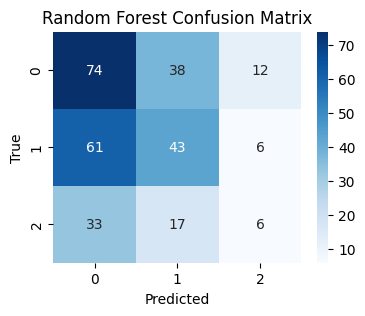

In [185]:
# Data Splitting, Model Training, Cross-Validation, and Evaluation
from xgboost import XGBClassifier

# Prepare features and target
df_model = pd.get_dummies(df_feat[features + ['congestion_class']], columns=['weather_road','location_id'], drop_first=True)
X = df_model.drop('congestion_class', axis=1)
y = df_model['congestion_class']

# Split data (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print('Random Forest Accuracy:', accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# XGBoost
xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print('XGBoost Accuracy:', accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# Cross-validation (Random Forest)
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print('Random Forest 5-fold CV Accuracy:', cv_scores.mean())

# Confusion Matrix (Random Forest)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()

In [187]:
# # SMOTE + XGBoost (with GridSearchCV) for best model accuracy
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBClassifier

# # 1. Apply SMOTE to training data only (avoid data leakage)
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# # 2. Define parameter grid for XGBoost
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.7, 1.0],
#     'colsample_bytree': [0.7, 1.0]
# }

# # 3. Initialize XGBoost classifier
# xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# # 4. GridSearchCV on SMOTE-resampled data
# grid = GridSearchCV(
#     estimator=xgb_base,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=3,
#     n_jobs=-1,
#     verbose=1
# )
# grid.fit(X_resampled, y_resampled)

# print("🏆 Best Params:", grid.best_params_)
# print("🏆 Best CV Accuracy:", grid.best_score_)

# # 5. Evaluate best estimator on original test set
# best_xgb = grid.best_estimator_
# y_pred_best = best_xgb.predict(X_test)

# print("\n🎯 Test Set Accuracy:", accuracy_score(y_test, y_pred_best))
# print("\n🎯 Classification Report:\n", classification_report(y_test, y_pred_best))

# # 6. Confusion matrix
# plt.figure(figsize=(5,4))
# sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Greens')
# plt.title("Confusion Matrix (Best XGBoost + SMOTE)")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()

In [ ]:
# Save cleaned dataset to CSV
df.to_csv("cleaned_traffic_dataset.csv", index=False)
print("Cleaned dataset saved as cleaned_traffic_dataset.csv")

Cleaned dataset saved as cleaned_traffic_dataset.csv
